# 0. Setup the Environment

In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/jx8fh/Projects/LaMoD
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from modules.data import check_dict

/sfs/qumulo/qhome/jx8fh/Projects/LaMoD


In [2]:
!nvidia-smi

Tue Jul 23 11:19:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:07:00.0 Off |                    0 |
| N/A   30C    P0             63W /  400W |     262MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
# setup device
import os
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 1. Load Config

In [4]:
import json
# config_filename = 'configs/baseline-StrainNet.json'
# config_filename = 'configs/baseline-UNetR.json'
config_filename = 'configs/baseline-TransUNet.json'
config = json.load(open(config_filename, 'r'))

# 2. Load Data

In [5]:
# # Load raw data
# train_data = np.load(config['data']['train'], allow_pickle=True).tolist()
# val_data = np.load(config['data']['val'], allow_pickle=True).tolist()
# test_data = np.load(config['data']['test'], allow_pickle=True).tolist()

# # Build datasets
# from modules.dataset import VideoVolDataset
# train_dataset = VideoVolDataset(train_data, config['datasets']['train'])
# val_dataset = VideoVolDataset(val_data, config['datasets']['val'])
# test_dataset = VideoVolDataset(test_data, config['datasets']['test'])

# datasets = {
#     'train': train_dataset,
#     'val': val_dataset,
#     'test': test_dataset
# }
from modules.dataset import VideoVolDataset
datasets = {}
for dataset_name in ['train', 'val', 'test']:
    # Load raw data
    curr_data = np.load(config['data'][dataset_name], allow_pickle=True).tolist()
    # Build dataset
    curr_dataset = VideoVolDataset(curr_data, config['datasets'][dataset_name])
    # Add to datasets dict
    datasets[dataset_name] = curr_dataset

In [6]:
check_dict(datasets['train'].data[0])

ori_n_frames                                                 22                  
augmented                                                    False               
DENSE_slice_mat_filename                                     /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/00_Circle_V10_auto.1_ROI.1.mat
DENSE_slice_location                                         61.970369270087     
subject_id                                                   00_Circle_V10-DENSE 
slice_idx                                                    0                   
slice_full_id                                                00_Circle_V10-0     
full_name                                                    00_Circle_V10-DENSE_0
DENSE_disp                                                   (2, 40, 48, 48)     
myo_masks                                                    (1, 40, 128, 128)   


In [7]:
check_dict(datasets['train'][0])

vol                                                          (1, 40, 128, 128)   
disp                                                         (2, 40, 48, 48)     
ori_n_frames                                                 22                  
augmented                                                    False               
DENSE_slice_mat_filename                                     /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/00_Circle_V10_auto.1_ROI.1.mat
DENSE_slice_location                                         61.970369270087     
subject_id                                                   00_Circle_V10-DENSE 
slice_idx                                                    0                   
slice_full_id                                                00_Circle_V10-0     
full_name                                                    00_Circle_V10-DENSE_0


# 3. Build Model

In [8]:
from models import build_model
networks = {}
for model_name, model_config in config['networks'].items():
    networks[model_name] = build_model(model_config)
    networks[model_name] = networks[model_name].to(device)

unused kwargs: {'type': 'TransUNet3D'}


# 4. Build Trainer

In [9]:
from modules.trainer import build_trainer
# For debug: use small epoch number and batch size
config['training']['epochs'] = 10
config['training']['batch_size'] = 12
trainer = build_trainer(config['training'], device, config)

# 5. Training

In [10]:
exp_dict, trained_models, wandb_experiment = trainer.train(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    use_tensorboard=False,
    tensorboard_log_dir='tensorboard',
    use_wandb=False)

Loss DENSE_disp_reconstruction_MSE is disabled
Loss DENSE_disp_reconstruction_EPE is disabled
motion_regression lr_scheduler: <torch.optim.lr_scheduler.StepLR object at 0x7f617183c280>


45it [00:07,  5.71it/s]00:00<?, ?it/s]
9it [00:01,  6.78it/s].823e-01:   0%|          | 0/10 [00:07<?, ?it/s]
Epoch 0 | Train Loss 1.823e-01:  10%|█         | 1/10 [00:09<01:23,  9.24s/it]

{
    "train/DENSE_disp_reconstruction_L1": 0.21881844798723857,
    "train/total_loss": 0.9964674770832062,
    "train/DENSE_disp_reconstruction_error": 0.7776490290959676,
    "val/DENSE_disp_reconstruction_L1": 0.23073346416155496,
    "val/total_loss": 1.0980176362726424,
    "val/DENSE_disp_reconstruction_error": 0.8672841721110873
}


45it [00:09,  4.93it/s]
9it [00:03,  2.65it/s].571e-01:  10%|█         | 1/10 [00:18<01:23,  9.24s/it]
Epoch 1 | Train Loss 1.571e-01:  20%|██        | 2/10 [00:21<01:29, 11.21s/it]

{
    "train/DENSE_disp_reconstruction_L1": 0.17377578715483347,
    "train/total_loss": 0.6654992305570179,
    "train/DENSE_disp_reconstruction_error": 0.4917234434021844,
    "val/DENSE_disp_reconstruction_L1": 0.17424991809659535,
    "val/total_loss": 0.6715853851702478,
    "val/DENSE_disp_reconstruction_error": 0.4973354670736525
}


45it [00:06,  6.51it/s]
9it [00:00, 19.47it/s].401e-01:  20%|██        | 2/10 [00:28<01:29, 11.21s/it]
Epoch 2 | Train Loss 1.401e-01:  30%|███       | 3/10 [00:29<01:06,  9.48s/it]

{
    "train/DENSE_disp_reconstruction_L1": 0.15801540894640817,
    "train/total_loss": 0.5650014547838105,
    "train/DENSE_disp_reconstruction_error": 0.40698604583740233,
    "val/DENSE_disp_reconstruction_L1": 0.16037384420633316,
    "val/total_loss": 0.5836291718814108,
    "val/DENSE_disp_reconstruction_error": 0.4232553276750777
}


45it [00:11,  4.06it/s]
9it [00:00, 13.17it/s].472e-01:  30%|███       | 3/10 [00:40<01:06,  9.48s/it]
Epoch 3 | Train Loss 1.472e-01:  40%|████      | 4/10 [00:41<01:02, 10.40s/it]

{
    "train/DENSE_disp_reconstruction_L1": 0.14920581446753609,
    "train/total_loss": 0.5159677184290357,
    "train/DENSE_disp_reconstruction_error": 0.36676190396149955,
    "val/DENSE_disp_reconstruction_L1": 0.17180545959207746,
    "val/total_loss": 0.6642415871222814,
    "val/DENSE_disp_reconstruction_error": 0.49243612753020394
}
Epochs without improvement: 1 / 30


45it [00:11,  3.98it/s]
9it [00:03,  2.92it/s].186e-01:  40%|████      | 4/10 [00:52<01:02, 10.40s/it]
Epoch 4 | Train Loss 1.186e-01:  50%|█████     | 5/10 [00:55<00:59, 11.86s/it]

{
    "train/DENSE_disp_reconstruction_L1": 0.14283304959535598,
    "train/total_loss": 0.4815126520064142,
    "train/DENSE_disp_reconstruction_error": 0.3386796024110582,
    "val/DENSE_disp_reconstruction_L1": 0.14682942546076244,
    "val/total_loss": 0.5025401868753963,
    "val/DENSE_disp_reconstruction_error": 0.35571076141463387
}


45it [00:14,  3.05it/s]
9it [00:01,  5.22it/s].319e-01:  50%|█████     | 5/10 [01:10<00:59, 11.86s/it]
Epoch 5 | Train Loss 1.319e-01:  60%|██████    | 6/10 [01:12<00:53, 13.45s/it]

{
    "train/DENSE_disp_reconstruction_L1": 0.13554199404186673,
    "train/total_loss": 0.44247692128022514,
    "train/DENSE_disp_reconstruction_error": 0.3069349272383584,
    "val/DENSE_disp_reconstruction_L1": 0.15972565445635054,
    "val/total_loss": 0.5714464998907514,
    "val/DENSE_disp_reconstruction_error": 0.4117208454344008
}
Epochs without improvement: 1 / 30


45it [00:13,  3.29it/s]
9it [00:00, 18.58it/s].476e-01:  60%|██████    | 6/10 [01:25<00:53, 13.45s/it]
Epoch 6 | Train Loss 1.476e-01:  70%|███████   | 7/10 [01:26<00:41, 13.70s/it]

{
    "train/DENSE_disp_reconstruction_L1": 0.13104092263513142,
    "train/total_loss": 0.4200204042924775,
    "train/DENSE_disp_reconstruction_error": 0.2889794816573461,
    "val/DENSE_disp_reconstruction_L1": 0.14759774920013216,
    "val/total_loss": 0.5090717996160189,
    "val/DENSE_disp_reconstruction_error": 0.36147405041588676
}
Epochs without improvement: 2 / 30


45it [00:04,  9.80it/s]
9it [00:00, 13.41it/s].153e-01:  70%|███████   | 7/10 [01:30<00:41, 13.70s/it]
Epoch 7 | Train Loss 1.153e-01:  80%|████████  | 8/10 [01:31<00:22, 11.03s/it]

{
    "train/DENSE_disp_reconstruction_L1": 0.12578394926256603,
    "train/total_loss": 0.3900258744756381,
    "train/DENSE_disp_reconstruction_error": 0.26424192521307205,
    "val/DENSE_disp_reconstruction_L1": 0.1479384261700842,
    "val/total_loss": 0.5195430922839377,
    "val/DENSE_disp_reconstruction_error": 0.37160466611385345
}
Epochs without improvement: 3 / 30


45it [00:08,  5.13it/s]
9it [00:02,  3.61it/s].316e-01:  80%|████████  | 8/10 [01:40<00:22, 11.03s/it]
Epoch 8 | Train Loss 1.316e-01:  90%|█████████ | 9/10 [01:42<00:11, 11.12s/it]

{
    "train/DENSE_disp_reconstruction_L1": 0.12059807711177402,
    "train/total_loss": 0.367354945341746,
    "train/DENSE_disp_reconstruction_error": 0.246756868229972,
    "val/DENSE_disp_reconstruction_L1": 0.1388529067238172,
    "val/total_loss": 0.4624326734079255,
    "val/DENSE_disp_reconstruction_error": 0.3235797666841083
}


45it [00:10,  4.45it/s]
9it [00:05,  1.72it/s].199e-01:  90%|█████████ | 9/10 [01:53<00:11, 11.12s/it]
Epoch 9 | Train Loss 1.199e-01: 100%|██████████| 10/10 [01:58<00:00, 11.83s/it]

{
    "train/DENSE_disp_reconstruction_L1": 0.11452134086026086,
    "train/total_loss": 0.33701211810112,
    "train/DENSE_disp_reconstruction_error": 0.22249077724085914,
    "val/DENSE_disp_reconstruction_L1": 0.14320639769236246,
    "val/total_loss": 0.4878961741924286,
    "val/DENSE_disp_reconstruction_error": 0.3446897765000661
}
Epochs without improvement: 1 / 30


# 6. Test

In [11]:
# test model on training set
train_pred, train_performance_dict, _ = trainer.test(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    target_dataset='train',
    mode='test')

test_loss_dict:  {'train/DENSE_disp_reconstruction_L1': 0.12081701275375155, 'train/total_loss': 0.36683858550257153, 'train/DENSE_disp_reconstruction_error': 0.24602157274882}


In [12]:
# test model
test_pred, test_performance_dict, _ = trainer.test(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    target_dataset='test',
    mode='test')

test_loss_dict:  {'test/DENSE_disp_reconstruction_L1': 0.18189789023664263, 'test/total_loss': 0.6607413970761828, 'test/DENSE_disp_reconstruction_error': 0.47884350683954024}


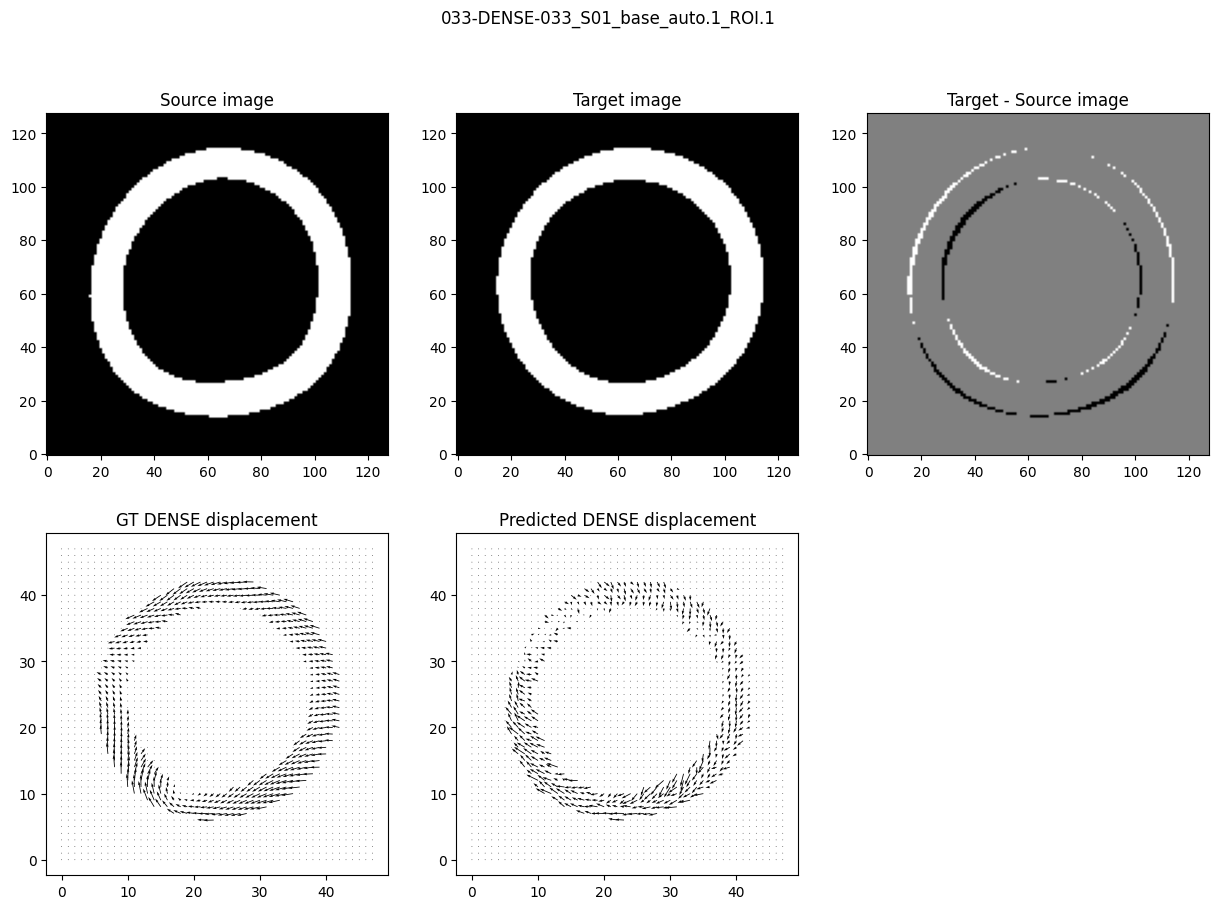

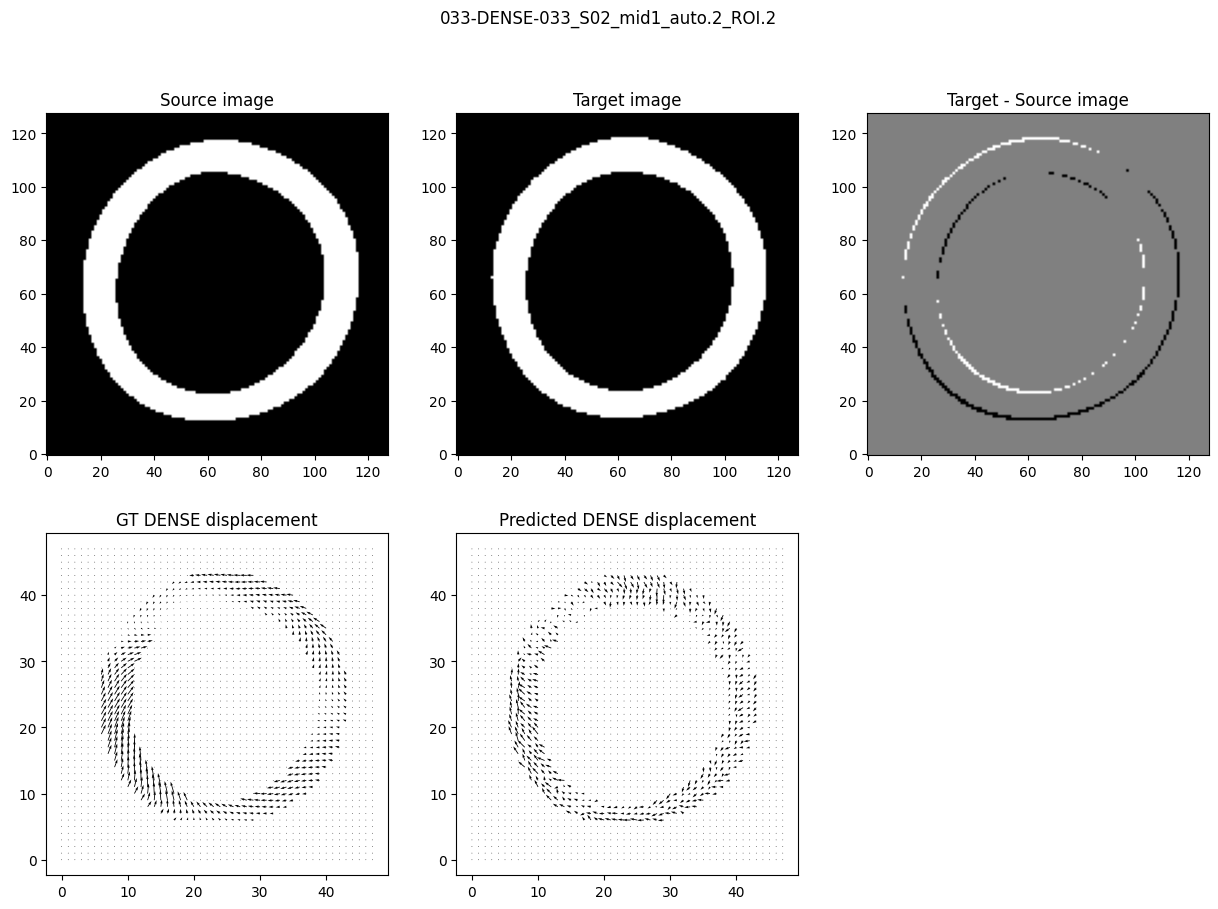

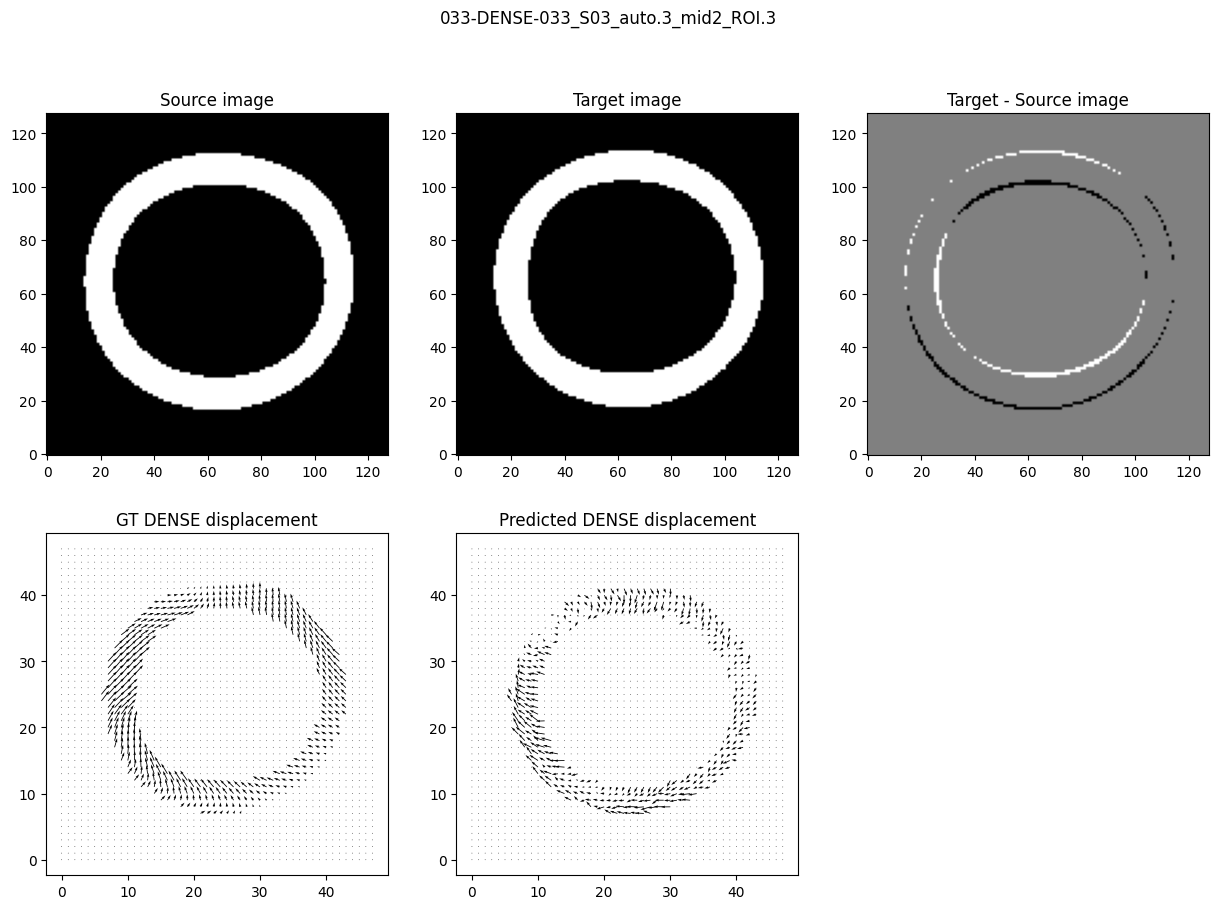

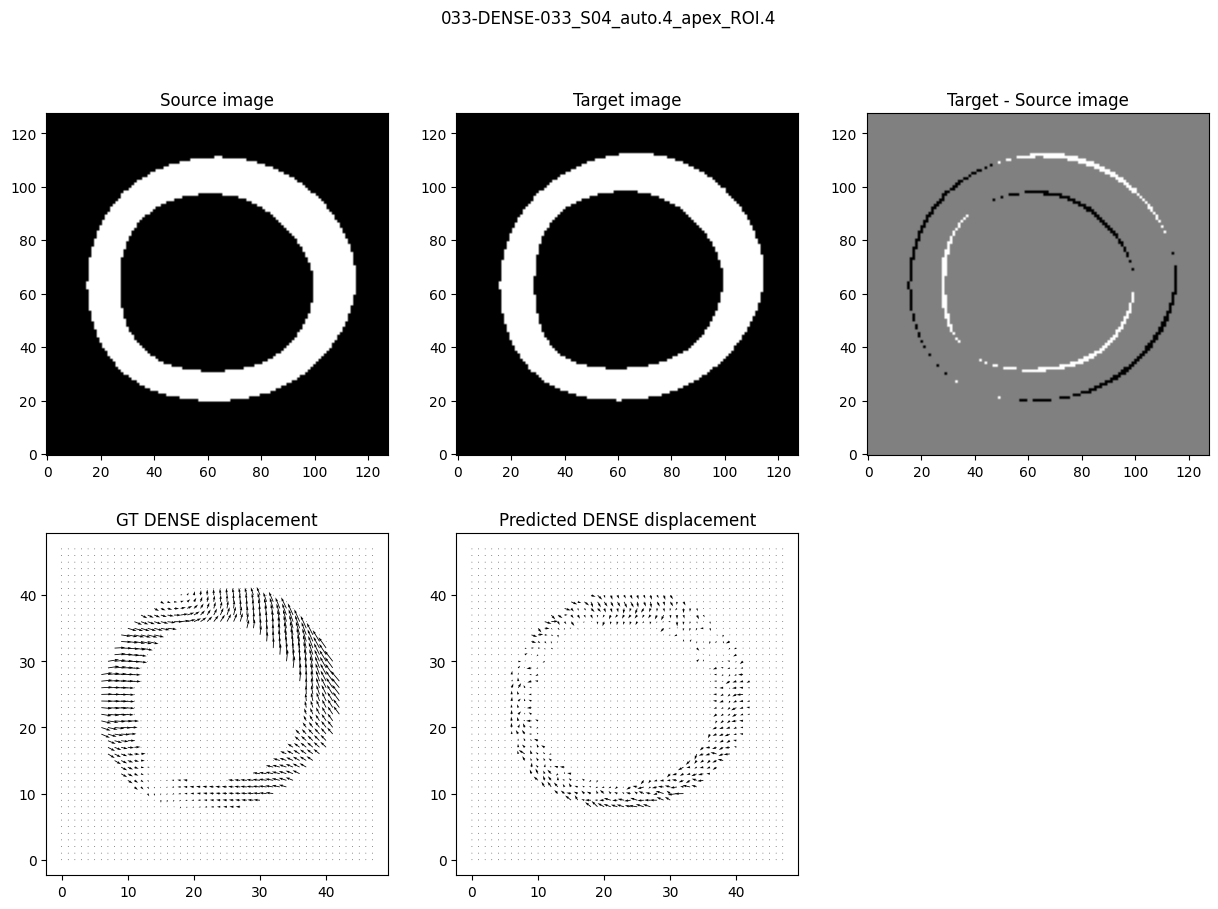

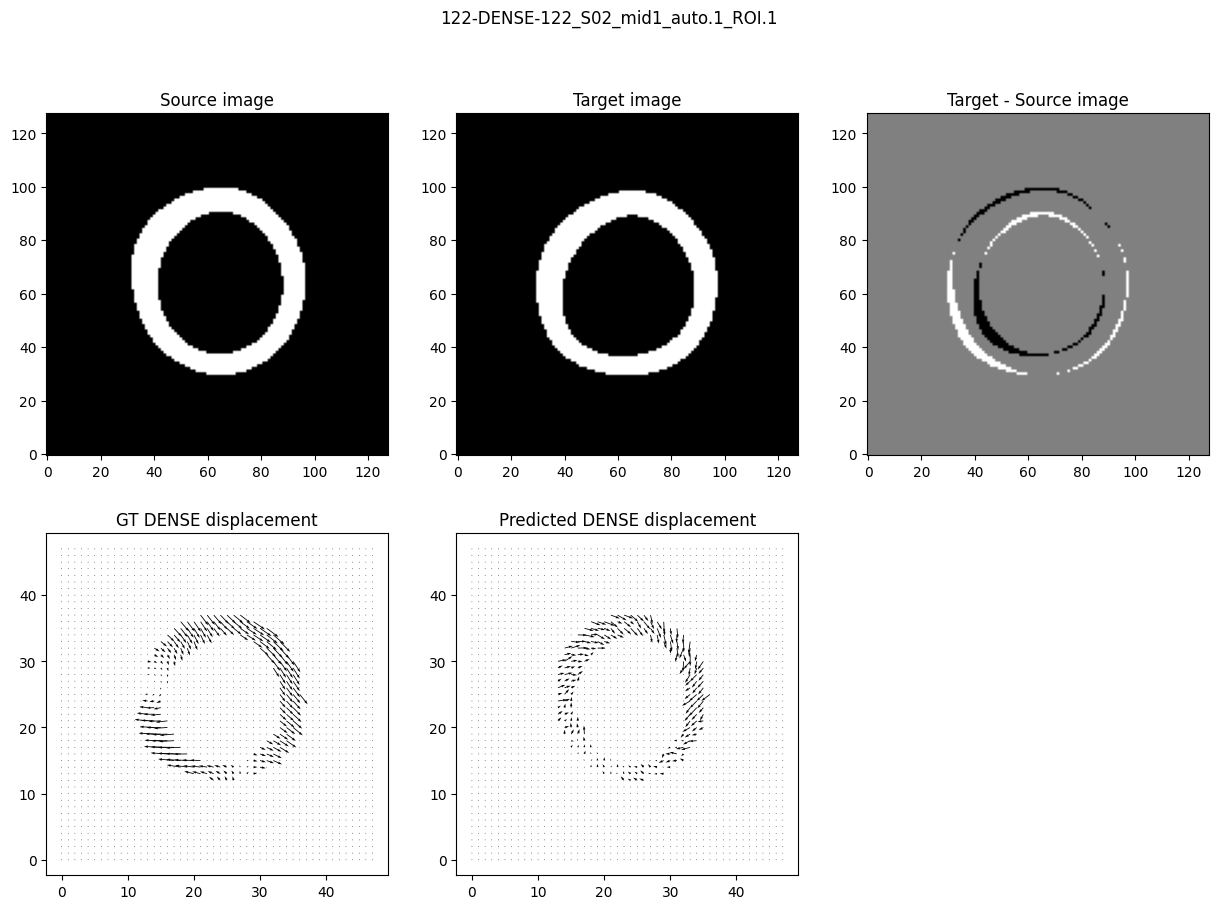

In [13]:
trainer.plot_results(test_pred, 
                     save_fig_dir='./test_results', 
                     save_plot=False, 
                     n_plot_patients = 2,
                     DENSE_quiver_scale=1,
                     reg_quiver_scale=1)

In [14]:
# save val and test predictions as npy file
import numpy as np
from pathlib import Path

saving_dir = Path(config['saving'].get('saving_dir', './test_results'))
saving_dir.mkdir(parents=True, exist_ok=True)

print('experiment results saving dir: ', saving_dir)

data_keys_to_pop = config['saving'].get('data_keys_to_pop', [])
for test_datum in test_pred:
    for key in data_keys_to_pop:
        if key in test_datum.keys():
            test_datum.pop(key)

# val_save_filename = config['saving'].get('val_save_filename', 'val_pred.npy')
test_save_filename = config['saving'].get('test_save_filename', 'test_pred.npy')
# np.save(Path(saving_dir, val_save_filename), val_pred)
np.save(Path(saving_dir, test_save_filename), test_pred)

experiment results saving dir:  test_results
